## 전처리한 데이터 가지고 오기

In [9]:
%pip install -q lightgbm scikit-learn optuna shap

Note: you may need to restart the kernel to use updated packages.


In [10]:
# ライブラリのインポート
import pandas as pd
import shap
import lightgbm as lgb
import optuna
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from lightgbm import early_stopping, log_evaluation 
from imblearn.over_sampling import SMOTE

In [11]:
# データ読み込み
df = pd.read_csv('../data/combined_batches_domain_age_clean_5.csv')

best_params = {
    'boosting_type': 'goss',
    'learning_rate': 0.06327841043353384,
    'num_leaves': 146,
    'max_depth': 8,
    'min_data_in_leaf': 10,
    'feature_fraction': 0.7030308338054174,
    'lambda_l1': 2.675004037577347,
    'lambda_l2': 3.6723765368381396,
    'min_gain_to_split': 0.016110568656384494,
    'max_bin': 131
}

特徴量とラベルに分割

In [12]:
# 元特徴量から新しい比率を作成
df['digit_ratio'] = df['digits_count'] / (df['url_len'] + 1e-5)
df['meta_density'] = df['meta_count'] / (df['duration_sec'] + 1e-5)
df['performance_ratio'] = df['SpeedIndex'] / (df['duration_sec'] + 1e-5)

# ✅ 特徴量変換（log / clip / binning）
df['letters_count_log'] = np.log1p(df['letters_count'])  # log変換
df['letters_count_clipped'] = df['letters_count'].clip(upper=100)  # clip（極端値抑制）
df['url_len_binned'] = pd.cut(df['url_len'], bins=[0, 30, 60, 90, 200, 300], labels=False)  # 長さをカテゴリに

# ✅ log変換対象
df['TTFB_log'] = np.log1p(df['TTFB'])
df['LCP_log'] = np.log1p(df['LCP'])
df['FCP_log'] = np.log1p(df['FCP'])
# df['TBT_log'] = np.log1p(df['TBT'])  # ただし0の多さには注意

# ✅ 元の列は除外して、変換済みのみ使用
drop_cols = ['TTFB', 'LCP', 'FCP']
df = df.drop(columns=drop_cols)

# ✅ ターゲットと特徴量の分離
y = df['url_type']
X = df.drop(columns=['url_type'])

# ✅ bin・重み・変換特徴追加（削除ではなく活かす）
X['meta_count_high'] = (X['meta_count'] > 10).astype(int)
X['digit_ratio_bin'] = pd.cut(X['digit_ratio'], bins=[0, 0.02, 0.05, 0.1, 0.4], labels=False)
X['performance_ratio_log'] = np.log1p(X['performance_ratio'])

# ✅ 重み調整（例：letters_countが大きすぎるURLに対する罰則的特徴）
X['letters_penalty'] = (X['letters_count'] > 80).astype(int)

# ✅ 型フィルター（LightGBM用）
X = X.select_dtypes(include=['int64', 'float64', 'bool'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80134 entries, 0 to 80133
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   url                    80134 non-null  object 
 1   url_type               80134 non-null  int64  
 2   url_len                80134 non-null  int64  
 3   letters_count          80134 non-null  int64  
 4   digits_count           80134 non-null  int64  
 5   special_chars_count    80134 non-null  int64  
 6   shortened              80134 non-null  int64  
 7   is_domain_in_url       80134 non-null  int64  
 8   secure_http            80134 non-null  int64  
 9   redirect_count         80134 non-null  int64  
 10  duration_sec           80134 non-null  float64
 11  meta_count             80134 non-null  float64
 12  link_count             80134 non-null  float64
 13  title_count            80134 non-null  float64
 14  has_title              80134 non-null  bool   
 15  ha

学習・検証データに分割

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

LightGBMデータ形式に変換

In [15]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [16]:
# GOSS の場合は bagging 系のパラメータ削除（GOSSは使えない）
if best_params.get("boosting_type") == "goss":
    best_params.pop("bagging_fraction", None)
    best_params.pop("bagging_freq", None)

# 固定設定を追記
best_params.update({
    'objective': 'multiclass',
    'num_class': y.nunique(),
    'metric': 'multi_logloss',
    'verbosity': -1,
    'feature_pre_filter': False,
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0
})

# データセットの再構築
train_dataset = lgb.Dataset(X_train, label=y_train)
valid_dataset = lgb.Dataset(X_test, label=y_test)

# num_boost_round は早期終了されるので大きめにしておく（Optunaでの記録がない場合）
model = lgb.train(
    best_params,
    train_dataset,
    valid_sets=[train_dataset, valid_dataset],
    num_boost_round=1000,
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(period=10)
    ]
)

Training until validation scores don't improve for 30 rounds
[10]	training's multi_logloss: 0.635136	valid_1's multi_logloss: 0.639455
[20]	training's multi_logloss: 0.453797	valid_1's multi_logloss: 0.461692
[30]	training's multi_logloss: 0.365071	valid_1's multi_logloss: 0.376371
[40]	training's multi_logloss: 0.319198	valid_1's multi_logloss: 0.333985
[50]	training's multi_logloss: 0.286824	valid_1's multi_logloss: 0.305164
[60]	training's multi_logloss: 0.265337	valid_1's multi_logloss: 0.286434
[70]	training's multi_logloss: 0.249449	valid_1's multi_logloss: 0.273539
[80]	training's multi_logloss: 0.236553	valid_1's multi_logloss: 0.263656
[90]	training's multi_logloss: 0.225296	valid_1's multi_logloss: 0.255494
[100]	training's multi_logloss: 0.215349	valid_1's multi_logloss: 0.248914
[110]	training's multi_logloss: 0.207927	valid_1's multi_logloss: 0.24429
[120]	training's multi_logloss: 0.201266	valid_1's multi_logloss: 0.240372
[130]	training's multi_logloss: 0.194467	valid_1'

予測と評価

In [17]:
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)
print("📊 Classification Report")
print(classification_report(y_test, y_pred))

print("🧩 Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("\n🧩 전체 클래스 간 오분류 분석")

# 클래스 목록 가져오기 (0,1,2 외의 클래스도 대응 가능)
classes = sorted(set(y_test) | set(y_pred))

# y_test와 y_pred가 시리즈일 경우를 고려하여 numpy 배열로 변환
y_true = y_test.values if isinstance(y_test, pd.Series) else y_test
y_pred_np = y_pred if not isinstance(y_pred, pd.Series) else y_pred.values

# 모든 클래스 쌍 (i ≠ j)에 대해 루프
for i in classes:
    for j in classes:
        if i == j:
            continue  # 정답인 경우는 건너뜀 (오분류만 분석)

        # i → j로 오분류된 인스턴스를 찾음
        misclassified_mask = (y_true == i) & (y_pred_np == j)

        if misclassified_mask.sum() > 0:
            print(f"\n🔍 클래스 {i} → 클래스 {j} 로 오분류된 인스턴스 수: {misclassified_mask.sum()}")
            print(X_test[misclassified_mask].describe())
        else:
            print(f"\n✅ 클래스 {i} → 클래스 {j} 오분류 없음")

📊 Classification Report
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      5745
           1       0.97      0.99      0.98      5405
           2       0.88      0.85      0.87      4877

    accuracy                           0.92     16027
   macro avg       0.92      0.92      0.92     16027
weighted avg       0.92      0.92      0.92     16027

🧩 Confusion Matrix
[[5203   10  532]
 [   7 5372   26]
 [ 543  165 4169]]

🧩 전체 클래스 간 오분류 분석

🔍 클래스 0 → 클래스 1 로 오분류된 인스턴스 수: 10
          url_len  letters_count  digits_count  special_chars_count  \
count   10.000000       10.00000     10.000000            10.000000   
mean    89.000000       74.50000      5.300000            16.200000   
std     18.257419       14.66856      2.983287             3.359894   
min     76.000000       64.00000      2.000000            14.000000   
25%     79.250000       65.25000      3.250000            14.250000   
50%     81.000000       69.00000      4.5

重要な特徴量を可視化

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

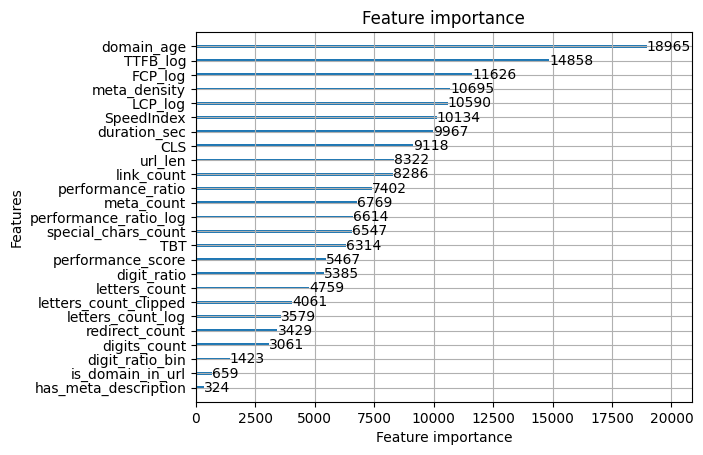

In [18]:
lgb.plot_importance(model, max_num_features=25)


--- Training URL String Only Model (Base) ---
[100]	training's multi_logloss: 0.423568	valid_1's multi_logloss: 0.4406
[200]	training's multi_logloss: 0.399827	valid_1's multi_logloss: 0.43106
[300]	training's multi_logloss: 0.387877	valid_1's multi_logloss: 0.429627
[400]	training's multi_logloss: 0.379009	valid_1's multi_logloss: 0.42935

📊 URL String Only Model (Base) Classification Report
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      5745
           1       0.89      0.97      0.93      5405
           2       0.75      0.70      0.72      4877

    accuracy                           0.82     16027
   macro avg       0.81      0.81      0.81     16027
weighted avg       0.81      0.82      0.81     16027


--- Training Full Feature Model (V8 + SMOTE) ---
Applying SMOTE...
[100]	training's multi_logloss: 0.21354	valid_1's multi_logloss: 0.249047
[200]	training's multi_logloss: 0.15744	valid_1's multi_logloss: 0.219627
[300]	

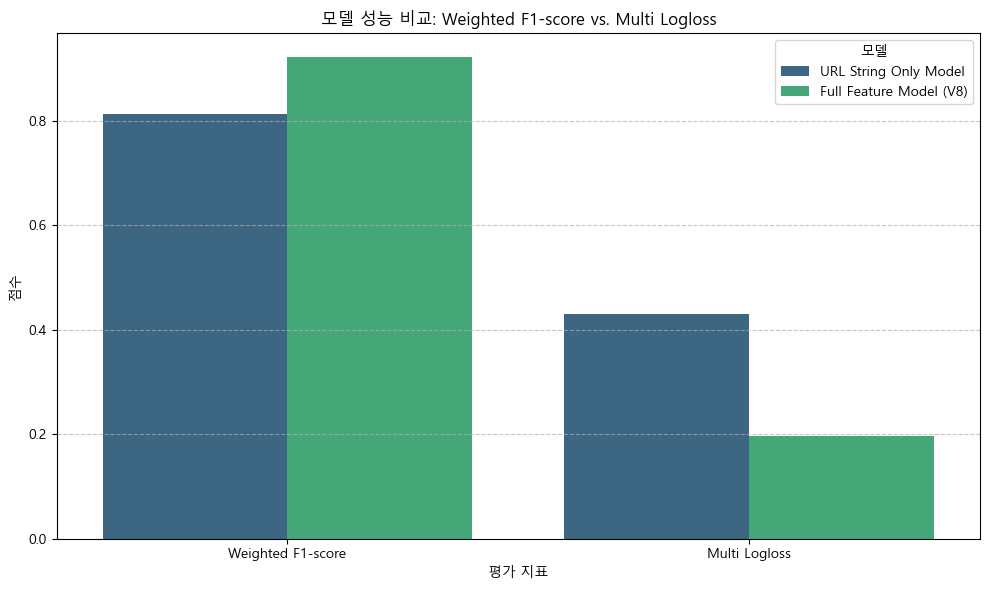

In [31]:
# -*- coding: utf-8 -*-
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from lightgbm import early_stopping, log_evaluation
from imblearn.over_sampling import SMOTE

# --- (이 위에는 기존 V8 코드의 데이터 로드, v8_best_params 정의, preprocess_data 함수,
#        train_and_evaluate_model 함수 등이 있다고 가정합니다.) ---

# 데이터 로드 (V8에서 사용된 클린 데이터)
try:
    df = pd.read_csv('../data/combined_batches_domain_age_clean_5.csv')
except FileNotFoundError:
    print("Error: 'combined_batches_domain_age_clean_5.csv' not found. Please check the file path.")
    exit()

# V8에서 사용된 최적의 하이퍼파라미터 (다른 컴에서 Optuna 돌린 결과)
v8_best_params = {
    'objective': 'multiclass',
    'num_class': df['url_type'].nunique(),
    'metric': 'multi_logloss',
    'boosting_type': 'goss',
    'learning_rate': 0.06327841043353384,
    'num_leaves': 146,
    'max_depth': 8,
    'min_data_in_leaf': 10,
    'feature_fraction': 0.7030308338054174,
    'lambda_l1': 2.675004037577347,
    'lambda_l2': 3.6723765368381396,
    'min_gain_to_split': 0.016110568656384494,
    'max_bin': 131,
    'verbosity': -1,
    'feature_pre_filter': False,
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0
}

# preprocess_data 함수 정의
def preprocess_data(dataframe):
    df_processed = dataframe.copy()
    df_processed['digit_ratio'] = df_processed['digits_count'] / (df_processed['url_len'] + 1e-5)
    df_processed['meta_density'] = df_processed['meta_count'] / (df_processed['duration_sec'] + 1e-5)
    df_processed['performance_ratio'] = df_processed['SpeedIndex'] / (df_processed['duration_sec'] + 1e-5)
    df_processed['letters_count_log'] = np.log1p(df_processed['letters_count'])
    df_processed['TTFB_log'] = np.log1p(df_processed['TTFB'])
    df_processed['LCP_log'] = np.log1p(df_processed['LCP'])
    df_processed['FCP_log'] = np.log1p(df_processed['FCP'])
    df_processed['letters_count_clipped'] = df_processed['letters_count'].clip(upper=100)
    df_processed['url_len_binned'] = pd.cut(df_processed['url_len'], bins=[0, 30, 60, 90, 200, 300], labels=False)
    df_processed['url_len_binned'] = df_processed['url_len_binned'].fillna(-1).astype(int)
    df_processed['meta_count_high'] = (df_processed['meta_count'] > 10).astype(int)
    df_processed['digit_ratio_bin'] = pd.cut(df_processed['digit_ratio'], bins=[0, 0.02, 0.05, 0.1, 0.4], labels=False)
    df_processed['digit_ratio_bin'] = df_processed['digit_ratio_bin'].fillna(-1).astype(int)
    df_processed['performance_ratio_log'] = np.log1p(df_processed['performance_ratio'])
    df_processed['letters_penalty'] = (df_processed['letters_count'] > 80).astype(int)
    drop_original_performance_cols = ['TTFB', 'LCP', 'FCP']
    df_processed = df_processed.drop(columns=drop_original_performance_cols, errors='ignore')
    return df_processed

# train_and_evaluate_model 함수 정의
def train_and_evaluate_model(X_features, y_target, model_name, params):
    print(f"\n--- Training {model_name} ---")
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y_target, test_size=0.2, random_state=42, stratify=y_target
    )
    if 'smote' in model_name.lower():
        print("Applying SMOTE...")
        sm = SMOTE(random_state=42)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
        train_data = lgb.Dataset(X_train_res, label=y_train_res)
    else:
        train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, test_data],
        num_boost_round=params.get('num_boost_round', 1000),
        callbacks=[
            early_stopping(stopping_rounds=30, verbose=False),
            log_evaluation(period=100)
        ]
    )
    y_pred_proba = model.predict(X_test)
    y_pred = y_pred_proba.argmax(axis=1)
    print(f"\n📊 {model_name} Classification Report")
    print(classification_report(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    weighted_f1 = report['weighted avg']['f1-score']
    accuracy = report['accuracy']
    multi_logloss = model.best_score['valid_1']['multi_logloss']
    feature_importances = pd.DataFrame({
        'feature': model.feature_name(),
        'importance': model.feature_importance(importance_type='gain')
    }).sort_values(by='importance', ascending=False)
    return model, accuracy, weighted_f1, multi_logloss, feature_importances

# --------------------------------------------------
# 모델 비교를 위한 특징 세트 정의
# --------------------------------------------------

# 원본 데이터 전처리 (V8 특징 엔지니어링 적용)
df_processed = preprocess_data(df)
y = df_processed['url_type']
df_processed = df_processed.drop(columns=['url', 'url_type'])

# 모든 특징 포함된 데이터프레임
X_full_features = df_processed.select_dtypes(include=['int64', 'float64', 'bool'])

# URL 문자열 자체에서 파생된 특징들만 (웹 성능 지표 및 domain_age 모두 제외)
url_string_only_features_names = [
    'url_len', 'letters_count', 'digits_count', 'special_chars_count',
    'shortened', 'is_domain_in_url',
    'digit_ratio',
    'letters_count_log', 'letters_count_clipped', 'url_len_binned',
    'letters_penalty'
]
X_url_string_only_features = X_full_features[
    [col for col in url_string_only_features_names if col in X_full_features.columns]
]

# --------------------------------------------------
# 모델 훈련 및 결과 저장
# --------------------------------------------------

results = {}
feature_importances_dict = {}

# 1) URL String Only 모델 훈련 (URL 문자열 특징만)
url_string_only_model, url_string_only_acc, url_string_only_f1, url_string_only_logloss, url_string_only_importances = \
    train_and_evaluate_model(X_url_string_only_features, y, "URL String Only Model (Base)", v8_best_params)

results["URL String Only Model"] = {
    "Accuracy": url_string_only_acc,
    "Weighted F1-score": url_string_only_f1,
    "Multi Logloss": url_string_only_logloss
}
feature_importances_dict["URL String Only Model"] = url_string_only_importances

# 2) Full Feature (V8) 모델 훈련 (모든 특징 포함)
full_model, full_acc, full_f1, full_logloss, full_importances = \
    train_and_evaluate_model(X_full_features, y, "Full Feature Model (V8 + SMOTE)", v8_best_params)

results["Full Feature Model (V8)"] = {
    "Accuracy": full_acc,
    "Weighted F1-score": full_f1,
    "Multi Logloss": full_logloss
}
feature_importances_dict["Full Feature Model (V8)"] = full_importances

# --------------------------------------------------
# 요청하신 성능 지표 비교 시각화 (X축을 지표로, 막대에 모델별 점수 표현)
# --------------------------------------------------

print("\n--- Model Performance Comparison (Selected Metrics) ---")

# 시각화할 지표와 모델별 점수를 DataFrame으로 재구성
plot_data = pd.DataFrame({
    'Metric': ['Weighted F1-score', 'Weighted F1-score', 'Multi Logloss', 'Multi Logloss'],
    'Model': ['URL String Only Model', 'Full Feature Model (V8)', 'URL String Only Model', 'Full Feature Model (V8)'],
    'Value': [results["URL String Only Model"]["Weighted F1-score"],
              results["Full Feature Model (V8)"]["Weighted F1-score"],
              results["URL String Only Model"]["Multi Logloss"],
              results["Full Feature Model (V8)"]["Multi Logloss"]]
})

print(plot_data)

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', hue='Model', data=plot_data, palette='viridis')

# Logloss는 낮을수록 좋으므로, Multi Logloss Y축의 범위를 조정하거나 시각화 방식에 따라 뒤집을 수 있습니다.
# 여기서는 F1-score와 Logloss의 스케일 차이가 크므로, Y축 스케일을 자동으로 맞춰주도록 합니다.
# Logloss는 낮을수록 좋다는 점을 명확히 주석이나 발표에서 언급해야 합니다.

plt.title('모델 성능 비교: Weighted F1-score vs. Multi Logloss')
plt.ylabel('점수')
plt.xlabel('평가 지표')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='모델', loc='upper right')
plt.tight_layout()
plt.show()

# --------------------------------------------------
# (이 아래는 기존 코드의 나머지 부분입니다. 예: 특징 그룹별 중요도 시각화 등)
# --------------------------------------------------